## CloudPareto Case Study: Recommendation Engine for Sellers

CloudPareto’s product portfolio supports two kinds of users: buyers and sellers. Our first product (Product B) provides a way for buyers to purchase items while our second product (Product S) allows sellers to identify new ways to pitch to the buyers. Product S is a social media type platform that allows sellers to:

- Post and interact with posts from other sellers as well as buyers
- Message other buyers and sellers
- Partner with other sellers to create stronger sales pitches
- Search for buyer requirements
- Connect directly to Product B to submit ideas directly to buyers

One of the ways the Analytics Team will support Product S is through building recommendation systems to provide users with more actionable insights.

For this case, you have been provided a list of seller posts that can be found in the Product S product feed. This information includes the Seller ID, the date of the post, the seller’s state, and the post text. We would like you to build a model to help sellers identify other sellers that they may want to partner with based on the post information.

During the case interview, you will be asked to discuss/show:
- Approach and why you chose it
- Insights gathered from the exercise
- What additional data elements you would consider to improve model accuracy
- Code (it will not be evaluated on cleanliness or production readiness)

We recognize this is a limited dataset. Our aim is not to have you develop a model with high accuracy in this short period but rather see your approach. Please spend no more than 3 hours on this.

## Raw Data Analysis

In [180]:
# Import Libraries
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# Upload data to dataframe (df)
df = pd.read_excel('CloudPareto_L3_DS_Case.xlsx')  

In [181]:
# Data Overview
df.head()

,SellerID,PostDate,StateName,PostText
0,Seller1,2021-11-04,Louisiana,"We specialize in the identification, effective..."
1,Seller2,2022-01-14,Maine,"We currently supply systems to FAA, TSA, and D..."
2,Seller3,2021-07-14,New Mexico,"Our mission is to engineer high-quality, innov..."
3,Seller4,2022-01-08,Tennessee,We are a certified woman-owned small business ...
4,Seller5,2021-07-26,Ohio,We have been providing Federal Government cust...


In [182]:
# Data Overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   SellerID   60 non-null     object        
 1   PostDate   60 non-null     datetime64[ns]
 2   StateName  60 non-null     object        
 3   PostText   60 non-null     object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.0+ KB


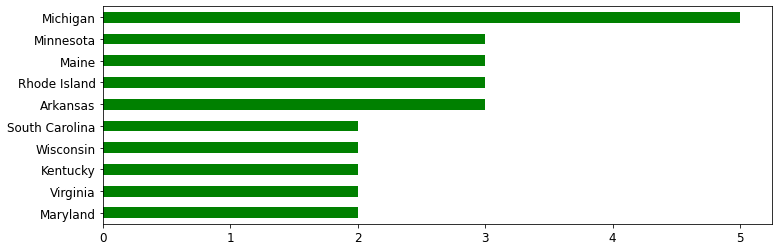

In [183]:
# Data Overview
df['StateName'].value_counts()[0:10].plot(kind='barh', figsize=[12,4], fontsize=12, color='green').invert_yaxis()

## Data Preprocessing

In [187]:
# Extract keywords from df (removes stopwords)
r = Rake()    

def rake_implement(x,r):
    r.extract_keywords_from_text(x)
    return r.get_ranked_phrases()

df['CleanedText'] =df['PostText'].apply(lambda x: rake_implement(x,r))
df['StringText']=df['CleanedText'].apply(lambda x: ' '.join(map(str, x)))

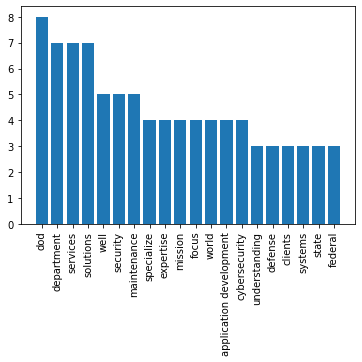

In [188]:
# View Most Common Terms among Seller Posts 
from collections import Counter
term_counts = Counter()
df['CleanedText'].apply(term_counts.update)

a = term_counts.most_common(20)
word_counts = [[ i for i, j in a ],
       [ j for i, j in a ]]
keys = word_counts[0]
values = word_counts[1]
plt.bar(keys, values)
plt.xticks(rotation = 90)
plt.show()

In [189]:
# df cleanup and visualization
df = df.drop(columns='CleanedText')
df.head()

,SellerID,PostDate,StateName,PostText,StringText
0,Seller1,2021-11-04,Louisiana,"We specialize in the identification, effective...",provide truly unique advice programmatic staff...
1,Seller2,2022-01-14,Maine,"We currently supply systems to FAA, TSA, and D...",custom medical device solutions worlds largest...
2,Seller3,2021-07-14,New Mexico,"Our mission is to engineer high-quality, innov...",devops consulting services generation software...
3,Seller4,2022-01-08,Tennessee,We are a certified woman-owned small business ...,owned small business founded staffing solution...
4,Seller5,2021-07-26,Ohio,We have been providing Federal Government cust...,providing federal government customers busines...


## Model Development

In [190]:
# Create Model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()
count_matrix = count.fit_transform(df['StringText'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
print(cosine_sim)

[[1.         0.02037848 0.10700008 ... 0.13696602 0.01644434 0.06906825]
 [0.02037848 1.         0.07032108 ... 0.04364358 0.         0.03026138]
 [0.10700008 0.07032108 1.         ... 0.10025608 0.0945756  0.09930727]
 ...
 [0.13696602 0.04364358 0.10025608 ... 1.         0.01760902 0.03698001]
 [0.01644434 0.         0.0945756  ... 0.01760902 1.         0.1709352 ]
 [0.06906825 0.03026138 0.09930727 ... 0.03698001 0.1709352  1.        ]]


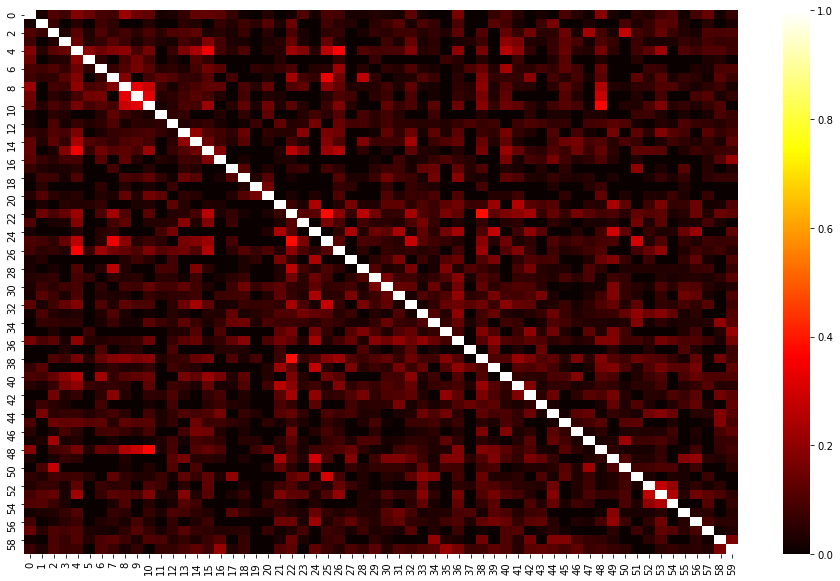

In [191]:
# Visualize similarities between Sellers' Posts
f, ax = plt.subplots(figsize=(16, 10))
ax = sns.heatmap(cosine_sim, cmap="hot")
plt.show()

In [192]:
# Build function to recommend top 10 Seller Partners for a Seller
indices = pd.Series(df['SellerID'])
def recommend(sellerid, cosine_sim = cosine_sim):
    rec_partners = []
    idx = indices[indices == sellerid].index[0]
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)
    top_indices = list(score_series.iloc[1:11].index)
    
    for i in top_indices:
        rec_partners.append(list(df['SellerID'])[i])
        
    return rec_partners

In [193]:
# Recommend Top Seller Partners for a Seller; Returns Ranked list of closest to least-close match
recommend('Seller1')

['Seller9',
 'Seller49',
 'Seller5',
 'Seller37',
 'Seller10',
 'Seller6',
 'Seller58',
 'Seller11',
 'Seller16',
 'Seller15']

## Results & Discussion

#### Approach and why you chose it
##### Assumptions
- Sellers with similar business ventures may want to create partnerships to form a more robust offering, whereas sellers with very different business ventures may not benefit from forming partnerships
- Product S is a digital platform and users would want to engage with one another in a digital way. Therefore, physical location is not taken into account in this assessment.
- Each Post represents a different Seller, with each Seller coming from a different Company. 

##### Approach Overview
- Create visualizations and data summaries to verify data is clean and gain understanding of data context and components.
- Perform NLP cleanup to remove stopwords and retain words of interest to the analysis.
- Develop relationship strength matrix for Sellers based on the similarity of posts.
- Use sklearn CountVectorizer to create matrix of the count of words per post. 
- Use cosine_similarity to calculate the similarity of each Seller's post.
- Create function to take as input a Seller, and return the top 10 ranked potential Seller partners based on max similarity score.

#### Insights gathered from the exercise
- There is a relatively low similarity scores between posts. 
- Many posts describe what a Seller does, but do not necessarily describe what they would be interested in in a sales partnership. We should explore additional posts and features to gain more accurate recommendations (See Below). 
- Many features are not shared by multiple sellers. We should do additional research/visualization to determine which features are predictive of likely Sales partnerships, and eliminate features which are less valuable from future models via NLP. 
- To determine the accuracy of our predictions, we will need to collect User Partnership, Platform Engagement, and User Feedback metrics to determine how accurate the current model is. After collecting this information, we can continue to tune our approach, select additional features, and eliminate unneeded features as needed.

#### What additional data elements you would consider to improve model accuracy
- Noise Reduction (Feature Filtration): Collect additional data on which features and keywords are most predictive of interest in partnerships. Remove unwanted features prior to matching. 
- Additional Feature Selection: Profile information from each seller to provide additional filtering, features and context. I.e. identifying which Company each Seller comes from, to determine if multiple Posts should be combined under a single Company for analysis purposes. I.e. Information on Industries of Interest (and the Seller's Industry) or target market could provide additional relevant features for analysis.
- Model Accuracy: Collect User Partnership, Platform Engagement, and User Feedback metrics to determine how accurate the current model is. Perform data analysis & visualization to understand areas where the model may be weak (underserved Seller markets, unpredicted partnerships, etc.). 
- Weights: As we collect additional features, we may want to alter the model to account for dynamic weighting of features to ensure more predictive features have a stronger influence on match rankings.
- Iterative Development: Use collection of model accuracy data to influence introduction of new features and elimination of noisy features, to continue improving the model.